In [2]:
import sys
sys.path.append("/home/ubuntu/workspaces/deepinv/")

In [3]:
from datetime import datetime
import deepinv as dinv
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing
from deepinv.models.complex import to_complex_denoiser

In [4]:
plt.style.use(['science','ieee'])

In [5]:
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
FIGURE_DIR = DATA_DIR / "latest"

# Pseudorandom Model

In [6]:
oversampling_ratios = torch.load(FIGURE_DIR / "pseudorandom" / "oversampling_ratios_spec.pt")

ratio_1 = torch.load(FIGURE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_0-1.pt")
ratio_2 = torch.load(FIGURE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_1-2.pt")
ratio_3 = torch.load(FIGURE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_2-9.pt")

ratio_4 = torch.load(FIGURE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_0-2.pt")
ratio_5 = torch.load(FIGURE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_2-9.pt")

In [22]:
oversampling_ratios_gd_spec = torch.cat([ratio_1, ratio_2, ratio_3])
oversampling_ratios_gd_spec.shape

torch.Size([148])

In [7]:
res_gd_rand_0_2 = torch.load(FIGURE_DIR / "pseudorandom" / "res_gd_rand_0-2.pt")
res_gd_rand_2_9 = torch.load(FIGURE_DIR / "pseudorandom" / "res_gd_rand_2-9.pt")
res_gd_rand = torch.concatenate((res_gd_rand_0_2.mean(dim=1), res_gd_rand_2_9.mean(dim=1)))
res_gd_rand.shape

torch.Size([149])

In [24]:
res_gd_spec_0_1 = torch.load(FIGURE_DIR / "pseudorandom" / "res_gd_spec_0-1.pt")
res_gd_spec_1_2 = torch.load(FIGURE_DIR / "pseudorandom" / "res_gd_spec_1-2.pt")
res_gd_spec_2_9 = torch.load(FIGURE_DIR / "pseudorandom" / "res_gd_spec_2-9.pt")
res_gd_spec = torch.concatenate((res_gd_spec_0_1.mean(dim=1), res_gd_spec_1_2.mean(dim=1), res_gd_spec_2_9.mean(dim=1)))
res_gd_spec.shape

torch.Size([148])

In [25]:
oversampling_ratios

tensor([1.0203e-04, 9.1827e-04, 2.5508e-03, 4.9995e-03, 8.2645e-03, 1.2346e-02,
        1.7243e-02, 2.2957e-02, 2.9487e-02, 3.6833e-02, 4.4995e-02, 5.3974e-02,
        6.3769e-02, 7.4380e-02, 8.5808e-02, 9.8051e-02, 1.1111e-01, 1.2499e-01,
        1.3968e-01, 1.5519e-01, 1.7151e-01, 1.8865e-01, 2.0661e-01, 2.2539e-01,
        2.4498e-01, 2.6538e-01, 2.8660e-01, 3.0864e-01, 3.3150e-01, 3.5517e-01,
        3.7966e-01, 4.0496e-01, 4.3108e-01, 4.5801e-01, 4.8577e-01, 5.1434e-01,
        5.4372e-01, 5.7392e-01, 6.0494e-01, 6.3677e-01, 6.6942e-01, 7.0289e-01,
        7.3717e-01, 7.7227e-01, 8.0818e-01, 8.4491e-01, 8.8246e-01, 9.2082e-01,
        9.6000e-01, 1.0000e+00, 1.0408e+00, 1.0824e+00, 1.1249e+00, 1.1681e+00,
        1.2122e+00, 1.2571e+00, 1.3028e+00, 1.3494e+00, 1.3967e+00, 1.4449e+00,
        1.4938e+00, 1.5436e+00, 1.5942e+00, 1.6456e+00, 1.6979e+00, 1.7509e+00,
        1.8048e+00, 1.8595e+00, 1.9150e+00, 1.9713e+00, 2.0285e+00, 2.0864e+00,
        2.1452e+00, 2.2048e+00, 2.2652e+

In [26]:
res_spec = torch.load(FIGURE_DIR / "pseudorandom" / "res_spec.pt").mean(dim=1)
res_spec.shape

torch.Size([149])

# Random Model

In [27]:
res_gd_rand_rpr = np.load(FIGURE_DIR / "random" / "res_gd_rand.npy").mean(axis=1)
res_gd_rand_rpr.shape

(100,)

In [28]:
res_spec_rpr = np.load(FIGURE_DIR / "random" / "res_spec.npy").mean(axis=1)
res_spec_rpr.shape

(100,)

In [29]:
res_gd_spec_rpr = np.load(FIGURE_DIR / "random" / "res_gd_spec.npy").mean(axis=1)
res_gd_spec_rpr.shape

(100,)

In [30]:
oversampling_ratios_rpr = np.linspace(0.1, 10, 100)
oversampling_ratios_rpr

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])

# Plot

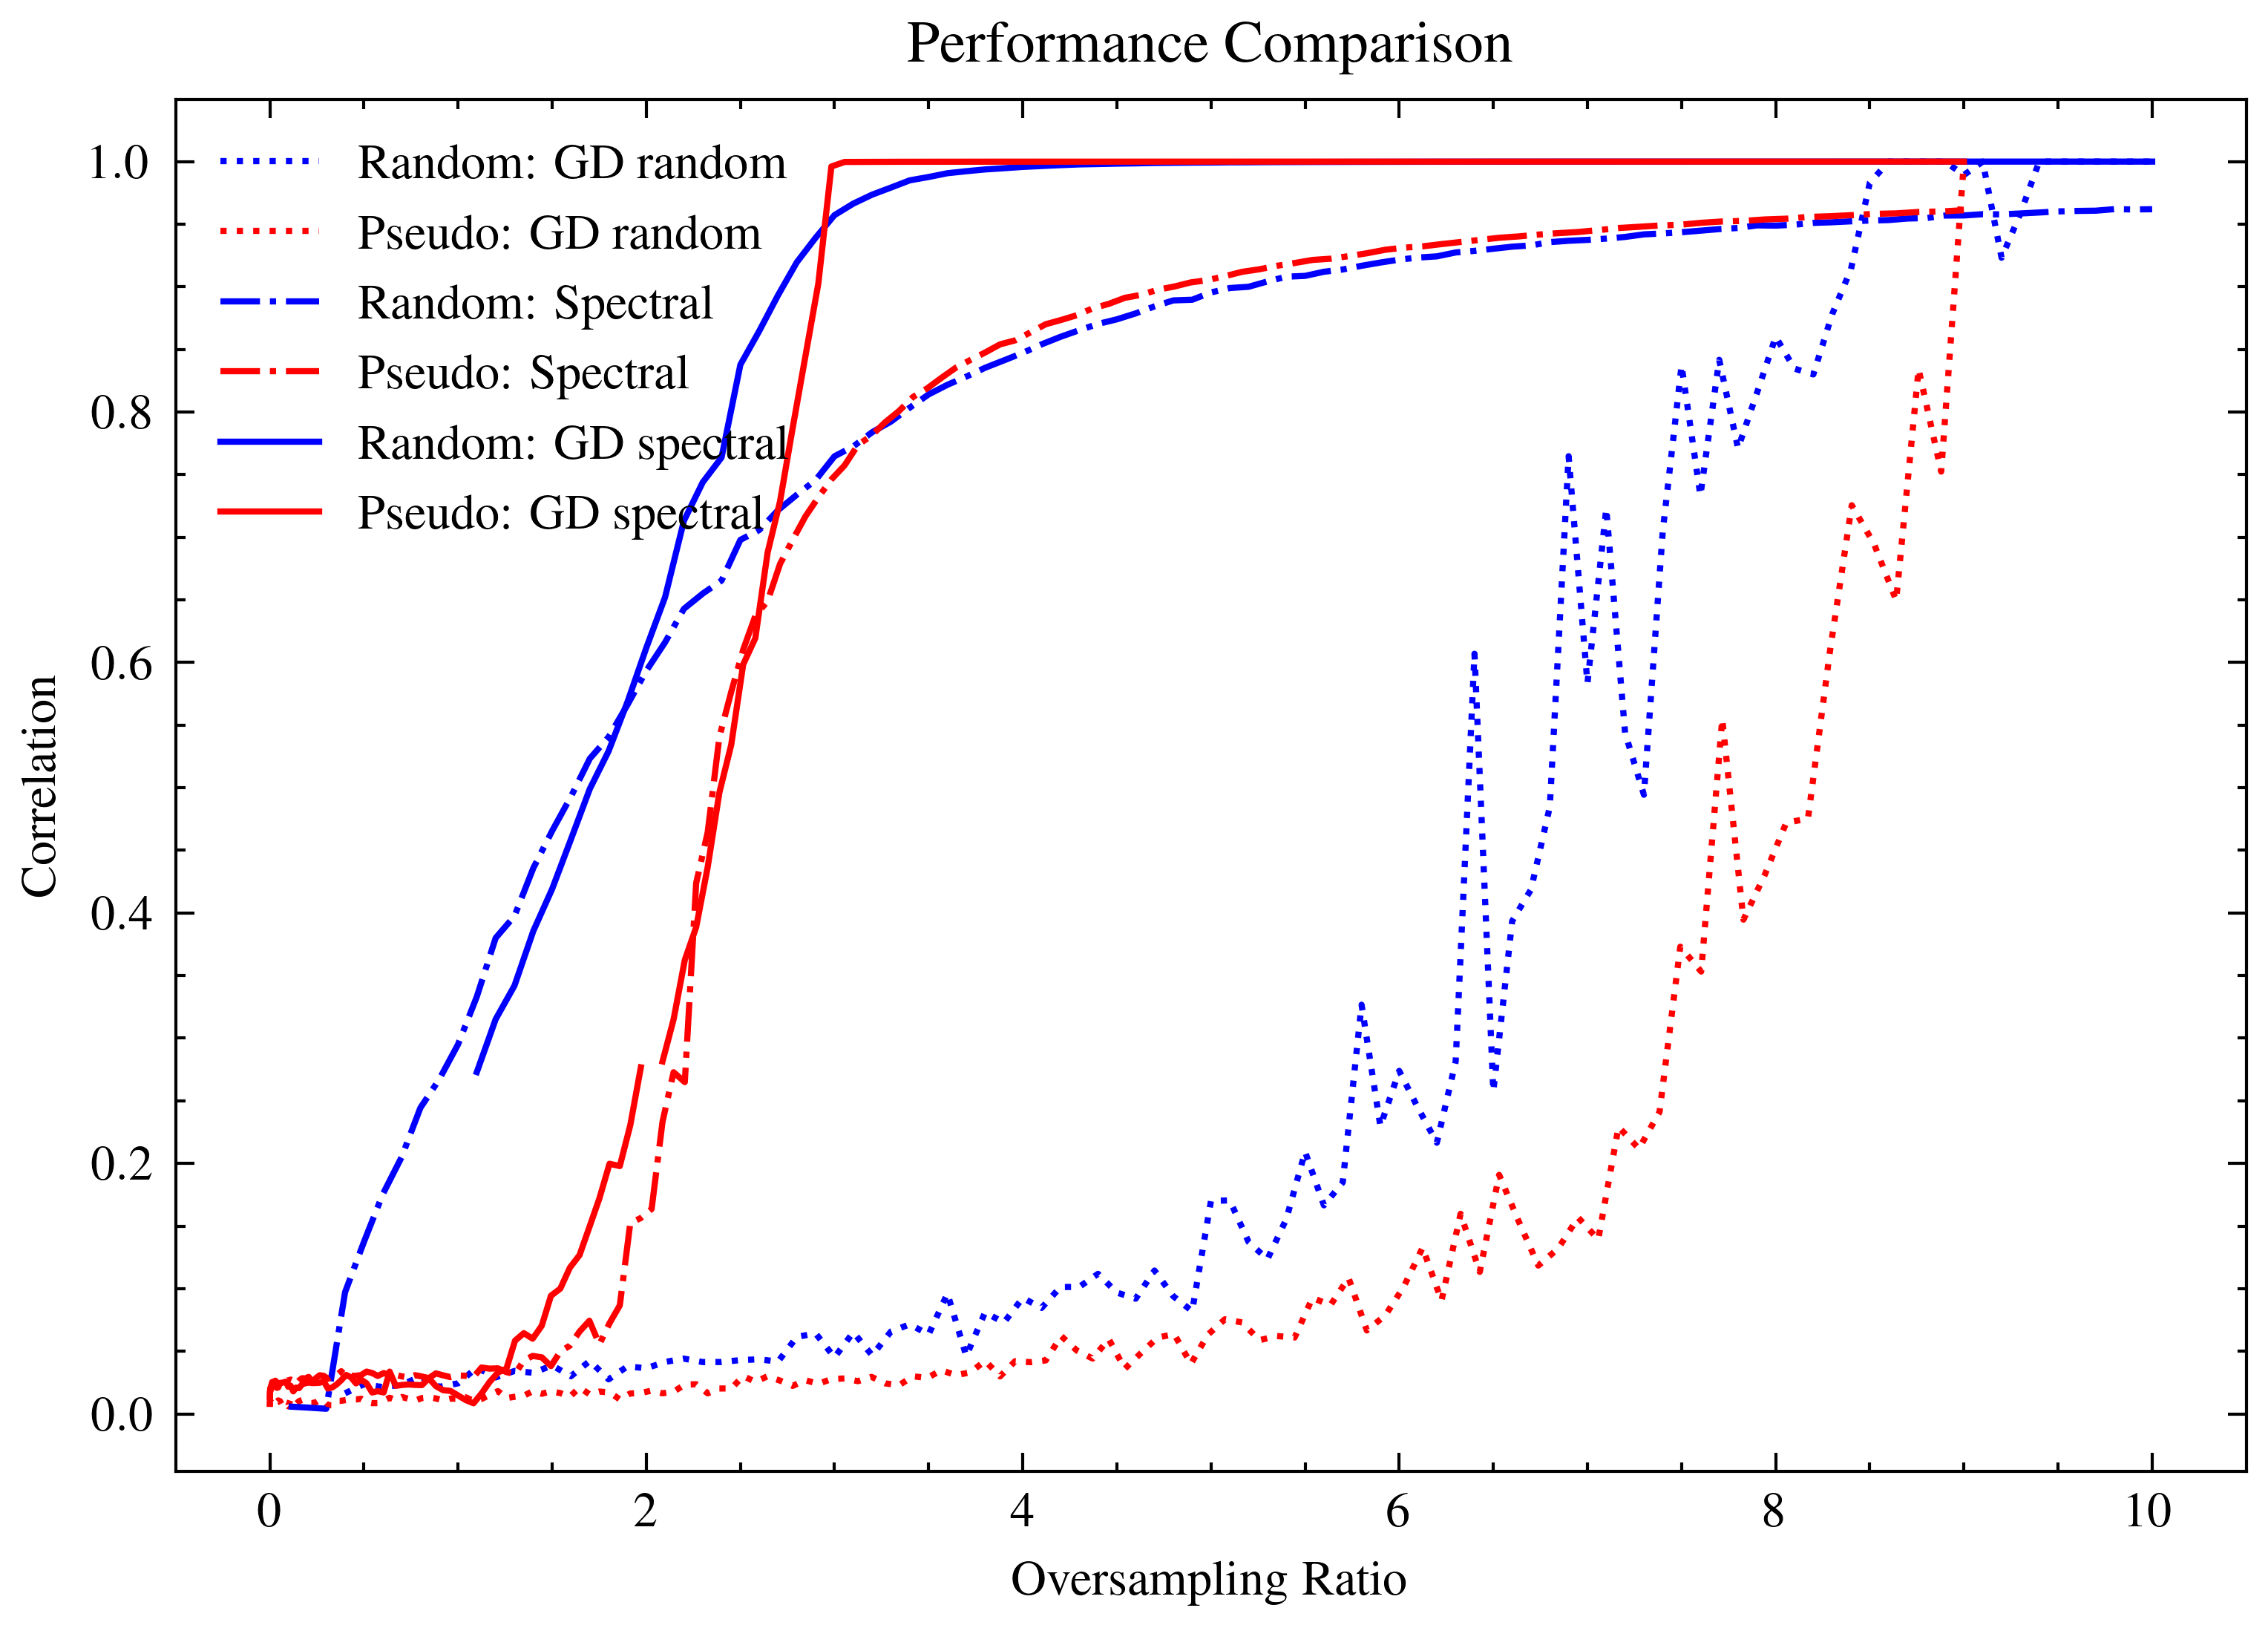

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(oversampling_ratios_rpr, res_gd_rand_rpr, label="Random: GD random", color="blue", linestyle="dotted")
plt.plot(oversampling_ratios, res_gd_rand, label="Pseudo: GD random", color="red", linestyle="dotted")
plt.plot(oversampling_ratios_rpr, res_spec_rpr, label="Random: Spectral", color="blue", linestyle="dashdot")
plt.plot(oversampling_ratios, res_spec, label="Pseudo: Spectral", color="red", linestyle="dashdot")
plt.plot(oversampling_ratios_rpr, res_gd_spec_rpr, label="Random: GD spectral", color="blue", linestyle="solid")
plt.plot(oversampling_ratios_gd_spec, res_gd_spec, label="Pseudo: GD spectral", color="red", linestyle="solid")
plt.xlabel("Oversampling Ratio")
plt.ylabel("Correlation")
plt.legend(loc="upper left")
plt.title("Performance Comparison")
plt.show()